In [1]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
import lightgbm as lgb
sns.set()

print("Files in the input folder:")
print(os.listdir("../input"))
train = pd.read_csv('../input/X_train.csv')
test = pd.read_csv('../input/X_test.csv')
y = pd.read_csv('../input/y_train.csv')
sub = pd.read_csv('../input/sample_submission.csv')
print("\nX_train shape: {}, X_test shape: {}".format(train.shape, test.shape))
print("y_train shape: {}, submission shape: {}".format(y.shape, sub.shape))

Files in the input folder:
['y_train.csv', 'sample_submission.csv', 'X_test.csv', 'X_train.csv']

X_train shape: (487680, 13), X_test shape: (488448, 13)
y_train shape: (3810, 3), submission shape: (3816, 2)


In [1]:
def feature_extraction(raw_frame):
    frame = pd.DataFrame()
    raw_frame['angular_velocity'] = raw_frame['angular_velocity_X'] + raw_frame['angular_velocity_Y'] + raw_frame['angular_velocity_Z']
    raw_frame['linear_acceleration'] = raw_frame['linear_acceleration_X'] + raw_frame['linear_acceleration_Y'] + raw_frame['linear_acceleration_Y']
    raw_frame['velocity_to_acceleration'] = raw_frame['angular_velocity'] / raw_frame['linear_acceleration']
    
    for col in raw_frame.columns[3:]:
        frame[col + '_mean'] = raw_frame.groupby(['series_id'])[col].mean()
        frame[col + '_std'] = raw_frame.groupby(['series_id'])[col].std()
        frame[col + '_max'] = raw_frame.groupby(['series_id'])[col].max()
        frame[col + '_min'] = raw_frame.groupby(['series_id'])[col].min()
        frame[col + '_max_to_min'] = frame[col + '_max'] / frame[col + '_min']
        
        frame[col + '_mean_abs_change'] = raw_frame.groupby('series_id')[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        frame[col + '_abs_max'] = raw_frame.groupby('series_id')[col].apply(lambda x: np.max(np.abs(x)))
    return frame

In [13]:
def feature_extraction(raw_frame):
    frame = pd.DataFrame()
    raw_frame['total_angular_velocity'] =np.sqrt(np.square(raw_frame['angular_velocity_X']) +np.square(raw_frame['angular_velocity_Y']) + np.square(raw_frame['angular_velocity_Z']))
    raw_frame['total_linear_acceleration'] = np.sqrt(np.square(raw_frame['linear_acceleration_X']) + np.square(raw_frame['linear_acceleration_Y']) +np.square(raw_frame['linear_acceleration_Z']))
    raw_frame['velocity_to_acceleration'] = raw_frame['total_angular_velocity'] / raw_frame['total_linear_acceleration']
    raw_frame['angular_velocity'] = raw_frame['angular_velocity_X'] + raw_frame['angular_velocity_Y'] + raw_frame['angular_velocity_Z']
    raw_frame['linear_acceleration'] = raw_frame['linear_acceleration_X'] + raw_frame['linear_acceleration_Y'] + raw_frame['linear_acceleration_Y']
    raw_frame['velocity_to_acceleration'] = raw_frame['linear_acceleration'] / raw_frame['angular_velocity']
    raw_frame['angular_velocity_XYZ'] =np.sqrt((raw_frame['angular_velocity_X']*raw_frame['angular_velocity_Y']) +(raw_frame['angular_velocity_Y']*raw_frame['angular_velocity_Z']) + (raw_frame['angular_velocity_Z']*raw_frame['angular_velocity_X']))
    raw_frame['linear_acceleration_XYZ'] =np.sqrt((raw_frame['linear_acceleration_X']*raw_frame['linear_acceleration_Y']) +(raw_frame['linear_acceleration_Y']*raw_frame['linear_acceleration_Z']) + (raw_frame['linear_acceleration_Z']*raw_frame['linear_acceleration_X'])
    for col in raw_frame.columns:
        frame[col + '_mean'] = raw_frame.groupby(['series_id'])[col].mean()
        frame[col + '_std'] = raw_frame.groupby(['series_id'])[col].std()
        frame[col + '_max'] = raw_frame.groupby(['series_id'])[col].max()
        frame[col + '_min'] = raw_frame.groupby(['series_id'])[col].min()
        frame[col + '_max_to_min'] = frame[col + '_max'] / frame[col + '_min']
        
        frame[col + '_mean_abs_change'] = raw_frame.groupby('series_id')[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        frame[col + '_abs_max'] = raw_frame.groupby('series_id')[col].apply(lambda x: np.max(np.abs(x)))
    return frame

SyntaxError: invalid syntax (<ipython-input-13-c25d92c77a40>, line 11)

In [14]:
for col in raw_frame.columns[8:]:
        frame[col + '_mean'] = raw_frame.groupby(['series_id'])[col].mean()
        frame[col + '_std'] = raw_frame.groupby(['series_id'])[col].std()
        frame[col + '_max'] = raw_frame.groupby(['series_id'])[col].max()
        frame[col + '_min'] = raw_frame.groupby(['series_id'])[col].min()
        frame[col + '_max_to_min'] = frame[col + '_max'] / frame[col + '_min']
        frame[col + '_mean_abs_change'] = raw_frame.groupby('series_id')[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        frame[col + '_abs_max'] = raw_frame.groupby('series_id')[col].apply(lambda x: np.max(np.abs(x)))
return frame

NameError: name 'raw_frame' is not defined

In [3]:
train_df = feature_extraction(train)
test_df = feature_extraction(test)
train_df.head()

,orientation_X_mean,orientation_X_std,orientation_X_max,orientation_X_min,orientation_X_max_to_min,orientation_X_mean_abs_change,orientation_X_abs_max,orientation_Y_mean,orientation_Y_std,orientation_Y_max,orientation_Y_min,orientation_Y_max_to_min,orientation_Y_mean_abs_change,orientation_Y_abs_max,orientation_Z_mean,orientation_Z_std,orientation_Z_max,orientation_Z_min,orientation_Z_max_to_min,orientation_Z_mean_abs_change,orientation_Z_abs_max,orientation_W_mean,orientation_W_std,orientation_W_max,orientation_W_min,orientation_W_max_to_min,orientation_W_mean_abs_change,orientation_W_abs_max,angular_velocity_X_mean,angular_velocity_X_std,angular_velocity_X_max,angular_velocity_X_min,angular_velocity_X_max_to_min,angular_velocity_X_mean_abs_change,angular_velocity_X_abs_max,angular_velocity_Y_mean,angular_velocity_Y_std,angular_velocity_Y_max,angular_velocity_Y_min,angular_velocity_Y_max_to_min,...,linear_acceleration_X_max,linear_acceleration_X_min,linear_acceleration_X_max_to_min,linear_acceleration_X_mean_abs_change,linear_acceleration_X_abs_max,linear_acceleration_Y_mean,linear_acceleration_Y_std,linear_acceleration_Y_max,linear_acceleration_Y_min,linear_acceleration_Y_max_to_min,linear_acceleration_Y_mean_abs_change,linear_acceleration_Y_abs_max,linear_acceleration_Z_mean,linear_acceleration_Z_std,linear_acceleration_Z_max,linear_acceleration_Z_min,linear_acceleration_Z_max_to_min,linear_acceleration_Z_mean_abs_change,linear_acceleration_Z_abs_max,angular_velocity_mean,angular_velocity_std,angular_velocity_max,angular_velocity_min,angular_velocity_max_to_min,angular_velocity_mean_abs_change,angular_velocity_abs_max,linear_acceleration_mean,linear_acceleration_std,linear_acceleration_max,linear_acceleration_min,linear_acceleration_max_to_min,linear_acceleration_mean_abs_change,linear_acceleration_abs_max,velocity_to_acceleration_mean,velocity_to_acceleration_std,velocity_to_acceleration_max,velocity_to_acceleration_min,velocity_to_acceleration_max_to_min,velocity_to_acceleration_mean_abs_change,velocity_to_acceleration_abs_max
series_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.758666,0.000363,-0.75822,-0.75953,0.998275,0.000015,0.75953,-0.634008,0.000471,-0.63306,-0.63456,0.997636,0.000018,0.63456,-0.105474,0.000432,-0.104610,-0.106140,0.985585,0.000051,0.106140,-0.106470,0.000389,-0.105590,-0.107050,0.986362,0.000042,0.107050,-0.002481,0.052800,0.107650,-0.16041,-0.671093,0.029984,0.16041,-0.003306,0.031544,0.072698,-0.079404,-0.915546,...,2.85380,-1.8644,-1.530680,0.714580,2.8538,2.984195,1.387790,5.3864,0.075417,71.421563,0.558104,5.3864,-9.320391,1.095040,-6.2681,-12.512,0.500967,0.810443,12.512,0.001745,0.054317,0.125978,-0.194071,-0.649136,0.037111,0.194071,6.231808,3.183764,12.03250,-0.027290,-440.912422,1.507869,12.03250,0.023497,0.222562,2.444038,-0.163152,-14.980095,0.057500,2.444038
1,-0.958606,0.000151,-0.95837,-0.95896,0.999385,0.000023,0.95896,0.241867,0.000499,0.24270,0.24074,1.008142,0.000070,0.24270,0.031650,0.000508,0.032341,0.030504,1.060222,0.000048,0.032341,-0.146876,0.000521,-0.145870,-0.148090,0.985009,0.000103,0.148090,0.004605,0.092309,0.283420,-0.25480,-1.112323,0.063036,0.28342,-0.007757,0.046523,0.112080,-0.134330,-0.834363,...,5.10020,-3.1934,-1.597107,1.242063,5.1002,2.768193,1.864457,6.6850,-2.149200,-3.110460,1.019259,6.6850,-9.388899,2.123065,-2.7449,-16.928,0.162151,1.625696,16.928,0.003054,0.114295,0.279769,-0.302061,-0.926201,0.072905,0.302061,5.658253,3.798361,12.51448,-4.179540,-2.994224,2.680602,12.51448,0.006958,0.115248,1.157278,-0.258428,-4.478137,0.057504,1.157278
2,-0.512057,0.001377,-0.50944,-0.51434,0.990473,0.000041,0.51434,-0.846171,0.000785,-0.84490,-0.84779,0.996591,0.000024,0.84779,-0.129371,0.000541,-0.128520,-0.130300,0.986339,0.000059,0.130300,-0.071082,0.000278,-0.070378,-0.071535,0.983826,0.000044,0.071535,0.002646,0.060168,0.141920,-0.15271,-0.929343,0.029703,0.15271,-0.009232,0.035530,0.091946,-0.107810,-0.852852,...,1.8

In [4]:
le = LabelEncoder()
target = le.fit_transform(y['surface'])

In [5]:
params = {
    'num_leaves': 10,
    'min_data_in_leaf': 10,
    'objective': 'multiclass',
    'max_depth': 17,
    'learning_rate': 0.01,
    "boosting": "gbdt",
    "bagging_freq": 7,
    "bagging_fraction": 0.8126672064208567,
    "bagging_seed": 11,
    "verbosity": -1,
    'reg_alpha': 0.1302650970728192,
    'reg_lambda': 0.3603427518866501,
    "num_class": 9,
    'nthread': -1
}

def multiclass_accuracy(preds, train_data):
    labels = train_data.get_label()
    pred_class = np.argmax(preds.reshape(9, -1).T, axis=1)
    return 'multi_accuracy', np.mean(labels == pred_class), True

t0 = time.time()
train_set = lgb.Dataset(train_df, label=target)
eval_hist = lgb.cv(params, train_set, nfold=10, num_boost_round=9999,
                   early_stopping_rounds=100, seed=19, feval=multiclass_accuracy)
num_rounds = len(eval_hist['multi_logloss-mean'])
# retrain the model and make predictions for test set
clf = lgb.train(params, train_set, num_boost_round=num_rounds)
predictions = clf.predict(test_df, num_iteration=None)
print("Timer: {:.1f}s".format(time.time() - t0))

Timer: 1083.5s


Validation logloss: 0.3149, accuracy: 0.8953


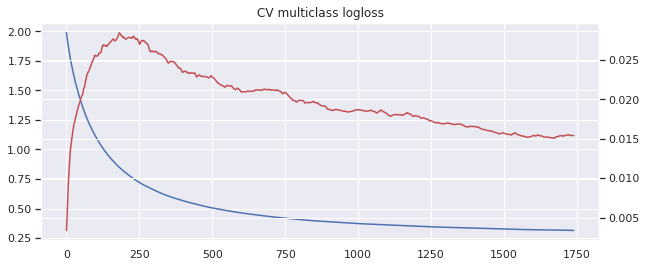

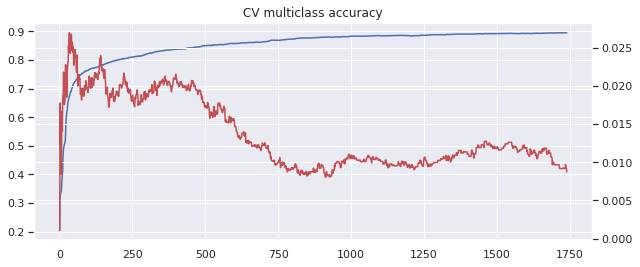

In [6]:
v1, v2 = eval_hist['multi_logloss-mean'][-1], eval_hist['multi_accuracy-mean'][-1]
print("Validation logloss: {:.4f}, accuracy: {:.4f}".format(v1, v2))
plt.figure(figsize=(10, 4))
plt.title("CV multiclass logloss")
num_rounds = len(eval_hist['multi_logloss-mean'])
ax = sns.lineplot(x=range(num_rounds), y=eval_hist['multi_logloss-mean'])
ax2 = ax.twinx()
p = sns.lineplot(x=range(num_rounds), y=eval_hist['multi_logloss-stdv'], ax=ax2, color='r')

plt.figure(figsize=(10, 4))
plt.title("CV multiclass accuracy")
num_rounds = len(eval_hist['multi_accuracy-mean'])
ax = sns.lineplot(x=range(num_rounds), y=eval_hist['multi_accuracy-mean'])
ax2 = ax.twinx()
p = sns.lineplot(x=range(num_rounds), y=eval_hist['multi_accuracy-stdv'], ax=ax2, color='r')

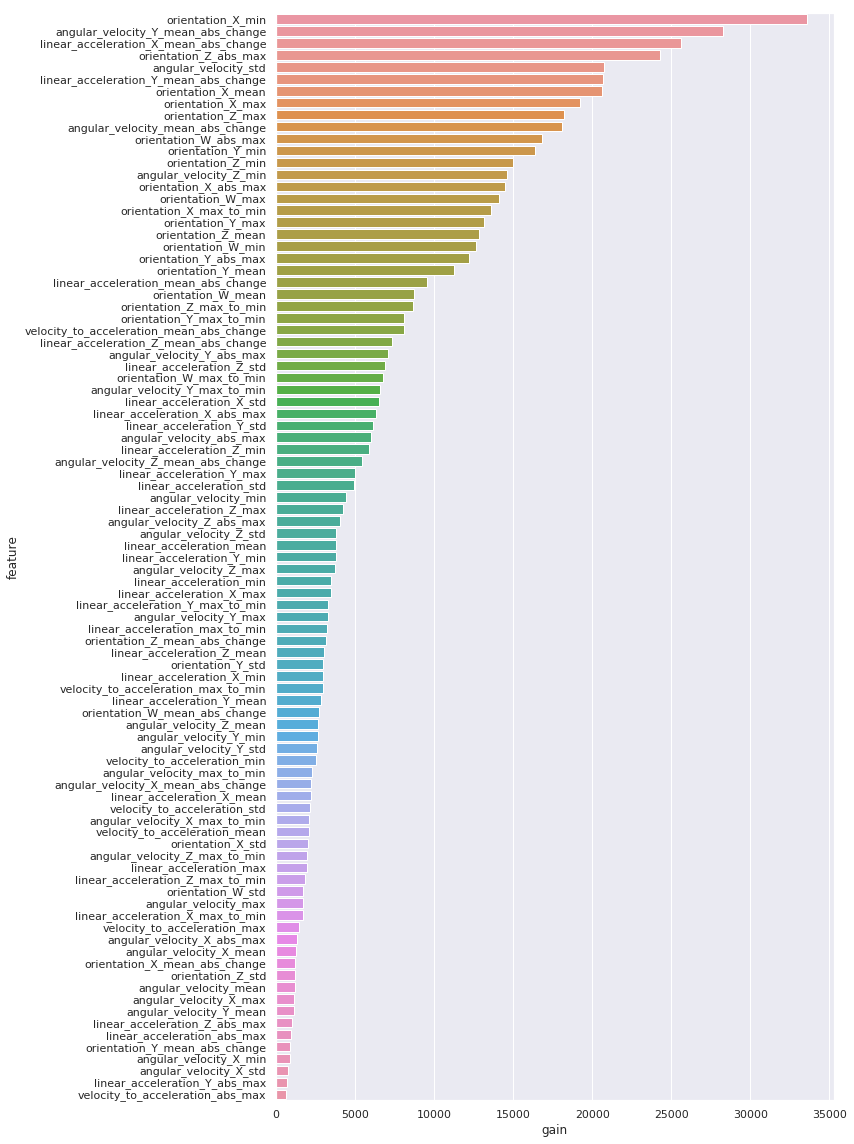

In [7]:
importance = pd.DataFrame({'gain': clf.feature_importance(importance_type='gain'),
                           'feature': clf.feature_name()})
importance.sort_values(by='gain', ascending=False, inplace=True)
plt.figure(figsize=(10, 20))
ax = sns.barplot(x='gain', y='feature', data=importance)

In [8]:
sub['surface'] = le.inverse_transform(predictions.argmax(axis=1))
sub.to_csv('lava_submission2.csv', index=False)
sub.head(3)

,series_id,surface
0,0,hard_tiles_large_space
1,1,carpet
2,2,tiled
